In [1]:
import matplotlib.pyplot as plt
from matplotlib import figure 
import tensorflow as tf
import numpy as np
import time
import seaborn as sns
# Dependency imports
import matplotlib
import tensorflow_probability as tfp
import tensorflow_addons as tfa
%matplotlib inline

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

X_train = X_train[:15000]
y_train = y_train[:15000]
X_train = np.expand_dims(X_train,axis=-1)
X_test = np.expand_dims(X_test,axis=-1)

#we can use this for regression
y_test = np.array([y_test], dtype='float32').T
y_train = np.array([y_train], dtype='float32').T

In [3]:
#we can to test a regular cnn first to do regression

In [4]:
def build_cnn(input_shape):
    
    ##model building
    model_in = tf.keras.layers.Input(shape=input_shape)
    #32 convolution filters used each of size 3x3
    conv_1 = tf.keras.layers.Conv2D(16, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape)(model_in)
    #convolutional layer with rectified linear unit activation
    #64 convolution filters used each of size 3x3
    max_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
    #randomly turn neurons on and off to improve convergence
    conv_2 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape)(max_1)
    max_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
    conv_3 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape)(max_2)
    drop_1 = tf.keras.layers.Dropout(0.25)(conv_3)
    #flatten since too many dimensions, we only want a classification output
    flat_1 = tf.keras.layers.Flatten()(drop_1)
    #fully connected to get all relevant data
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(flat_1)
    #output a softmax to squash the matrix into output probabilities
    model_out = tf.keras.layers.Dense(1, activation='relu')(dense_1)
    model = tf.keras.Model(model_in, model_out)
    return model

In [7]:
#here we build the network, instance an optizmier and compile it
input_shape = X_train.shape[1:]
epochs = 100
cnn = build_cnn(input_shape)
optimizer = tf.keras.optimizers.Adam(lr=0.001)
cnn.compile(loss='mse',\
            metrics=tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,)),\
            optimizer=optimizer)
history = cnn.fit(X_train, y_train, epochs=epochs, validation_split=0.1)

Epoch 1/100
422/422 [==============================] - 2s 4ms/step - loss: 3.1934 - r_square: 0.6184 - val_loss: 1.6350 - val_r_square: 0.8052
Epoch 2/100
422/422 [==============================] - 1s 3ms/step - loss: 1.3738 - r_square: 0.8358 - val_loss: 1.0244 - val_r_square: 0.8780
Epoch 3/100
422/422 [==============================] - 1s 3ms/step - loss: 1.0365 - r_square: 0.8761 - val_loss: 0.9694 - val_r_square: 0.8845
Epoch 4/100
422/422 [==============================] - 1s 3ms/step - loss: 0.7959 - r_square: 0.9049 - val_loss: 0.6997 - val_r_square: 0.9167
Epoch 5/100
422/422 [==============================] - 1s 3ms/step - loss: 0.6969 - r_square: 0.9167 - val_loss: 0.6340 - val_r_square: 0.9245
Epoch 6/100
422/422 [==============================] - 1s 3ms/step - loss: 0.5773 - r_square: 0.9310 - val_loss: 0.6250 - val_r_square: 0.9256
Epoch 7/100
422/422 [==============================] - 1s 3ms/step - loss: 0.5092 - r_square: 0.9391 - val_loss: 0.4866 - val_r_square: 0.9420

Epoch 58/100
422/422 [==============================] - 1s 3ms/step - loss: 0.0464 - r_square: 0.9945 - val_loss: 0.2500 - val_r_square: 0.9702
Epoch 59/100
422/422 [==============================] - 1s 3ms/step - loss: 0.0425 - r_square: 0.9949 - val_loss: 0.3487 - val_r_square: 0.9585
Epoch 60/100
422/422 [==============================] - 1s 3ms/step - loss: 0.0484 - r_square: 0.9942 - val_loss: 0.2372 - val_r_square: 0.9717
Epoch 61/100
422/422 [==============================] - 1s 3ms/step - loss: 0.0427 - r_square: 0.9949 - val_loss: 0.3049 - val_r_square: 0.9637
Epoch 62/100
422/422 [==============================] - 1s 3ms/step - loss: 0.0532 - r_square: 0.9936 - val_loss: 0.3299 - val_r_square: 0.9607
Epoch 63/100
422/422 [==============================] - 1s 3ms/step - loss: 0.0475 - r_square: 0.9943 - val_loss: 0.3249 - val_r_square: 0.9613
Epoch 64/100
422/422 [==============================] - 1s 3ms/step - loss: 0.0355 - r_square: 0.9958 - val_loss: 0.2154 - val_r_square:

Text(0, 0.5, 'yhat')

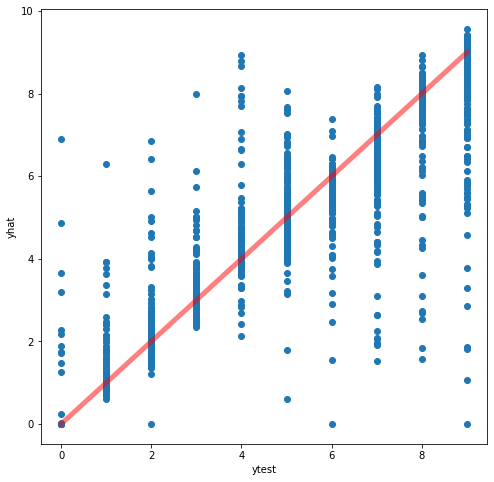

In [6]:
yhat = cnn.predict(X_test)
f, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(y_test,yhat)

ax.plot(np.unique(y_test),np.unique(y_test), linewidth=5, alpha=0.5, color='r')
ax.set_xlabel('ytest')
ax.set_ylabel('yhat')

In [19]:
#now try some uncertainty on the measurements

In [124]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def NLL(y, distr): 
    return -distr.log_prob(y) 

def normal_sp(params, bias_size=0, hyperparam=0.001): 
    n = params + bias_size
    c = np.log(np.expm1(1.))
    #return tfd.Normal(loc=params[:,0:1],\
    #                  scale=1e-3 + tf.math.softplus(0.01 * params[:,1:2]))
    return tfd.Normal(loc=params[...,:1],\
                      scale=1e-5 + tf.math.softplus(hyperparam * params[...,1:]))
    #return tfd.Normal(loc=params[...,:n],\
    #                  scale=1e-5 + tf.math.softplus(c * params[...,n:]))
    # both parameters are learnable

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    out = tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])
    return out

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    out = tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])
    return out

def build_bayes_cnn(input_shape):
    
    ##model building
    model_in = tf.keras.layers.Input(shape=input_shape)
    #32 convolution filters used each of size 3x3
    conv_1 = tfp.python.layers.Convolution2DFlipout(16, kernel_size=(3, 3),\
                                                    padding="same", \
                                                    activation='relu',\
                                                   input_shape=input_shape)(model_in)
    #convolutional layer with rectified linear unit activation
    max_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
    #randomly turn neurons on and off to improve convergence
    conv_2 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3),\
                                                    padding="same",\
                                                    activation='relu')(max_1)
    max_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
    conv_3 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3),\
                                                    padding="same",\
                                                    activation='relu')(max_2)
    max_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_3)
    #flatten since too many dimensions, we only want a classification output
    flat_1 = tf.keras.layers.Flatten()(max_3)
    #fully connected to get all relevant data
    #dense_1 = tfp.python.layers.DenseFlipout(128, activation='relu')(flat_1)
    #hidden = Dense(20, activation='relu')(dense_1)
    #params = Dense(2, activation='relu')(hidden)
    #dense_2 = tfp.python.layers.DenseFlipout(1, activation=None)(dense_1)
    #dense_2 = Dense(2, activation='relu')(dense_1)
    dense_2 = tfp.layers.DenseVariational(1+1, posterior_mean_field, \
                               prior_trainable,\
                               kl_weight=1/X_train.shape[0])(flat_1)
    model_out = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[...,:1],\
                                                                   scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])))(dense_2)
    
    #model_out = tfp.layers.DistributionLambda(normal_sp)(dense_2)
    model = tf.keras.Model(model_in, model_out)
    return model

def my_dist(params):
    return tfd.Normal(loc=params, scale=0.01)

def build_simple_bcnn(input_shape):
    model_in = tf.keras.layers.Input(shape=input_shape)
    conv_1 = tfp.python.layers.Convolution2DFlipout(16, kernel_size=(3, 3),\
                                                    padding="same", \
                                                    activation='relu',\
                                                   input_shape=input_shape)(model_in)
    max_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
    conv_2 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3),\
                                                padding="same", \
                                                activation='relu',\
                                               input_shape=input_shape)(max_1)
    max_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
    flat_1 = tf.keras.layers.Flatten()(max_2)
    dense_1 = Dense(64, activation='relu')(flat_1)
    params = Dense(1, activation='relu')(dense_1)
    dist = tfp.layers.DistributionLambda(my_dist)(params)
    model = Model(inputs=model_in, outputs=dist)
    return model
    

In [125]:
epochs = 100
#b_cnn = build_bayes_cnn(input_shape)

b_cnn = build_simple_bcnn(input_shape)
optimizer = tf.keras.optimizers.Adam(lr=0.005)
b_cnn.compile(loss=NLL,\
            metrics=tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,)),\
            optimizer=optimizer)
#b_cnn.summary()
history = b_cnn.fit(X_train, y_train, epochs=epochs, validation_split=0.1)

Epoch 1/100
422/422 [==============================] - 2s 5ms/step - loss: 66116.5859 - r_square: -0.3676 - val_loss: 25281.8398 - val_r_square: 0.5717
Epoch 2/100
422/422 [==============================] - 2s 5ms/step - loss: 14833.8379 - r_square: 0.7968 - val_loss: 12445.2959 - val_r_square: 0.8348
Epoch 3/100
422/422 [==============================] - 2s 5ms/step - loss: 10198.4766 - r_square: 0.8736 - val_loss: 9682.6992 - val_r_square: 0.8735
Epoch 4/100
422/422 [==============================] - 2s 4ms/step - loss: 8010.0586 - r_square: 0.9026 - val_loss: 8161.6484 - val_r_square: 0.8898
Epoch 5/100
422/422 [==============================] - 2s 4ms/step - loss: 6815.4434 - r_square: 0.9140 - val_loss: 7290.3125 - val_r_square: 0.8960
Epoch 6/100
422/422 [==============================] - 2s 4ms/step - loss: 5830.8110 - r_square: 0.9249 - val_loss: 6099.4414 - val_r_square: 0.9136
Epoch 7/100
422/422 [==============================] - 2s 5ms/step - loss: 5031.5752 - r_square: 0.9

422/422 [==============================] - 2s 5ms/step - loss: 1590.1527 - r_square: 0.9786 - val_loss: 4427.4189 - val_r_square: 0.9110
Epoch 56/100
422/422 [==============================] - 2s 5ms/step - loss: 1637.0129 - r_square: 0.9775 - val_loss: 3739.9226 - val_r_square: 0.9275
Epoch 57/100
422/422 [==============================] - 2s 4ms/step - loss: 1547.1014 - r_square: 0.9796 - val_loss: 3564.8257 - val_r_square: 0.9317
Epoch 58/100
422/422 [==============================] - 2s 4ms/step - loss: 1530.2876 - r_square: 0.9800 - val_loss: 3516.2051 - val_r_square: 0.9326
Epoch 59/100
422/422 [==============================] - 2s 5ms/step - loss: 1599.6080 - r_square: 0.9782 - val_loss: 3602.3047 - val_r_square: 0.9306
Epoch 60/100
422/422 [==============================] - 2s 5ms/step - loss: 1474.4668 - r_square: 0.9812 - val_loss: 3909.0430 - val_r_square: 0.9233
Epoch 61/100
422/422 [==============================] - 2s 4ms/step - loss: 1446.1956 - r_square: 0.9818 - val_lo

In [126]:
n_samples = 100 
b_yhat = b_cnn.predict(X_test)
for i in range(n_samples-1):
    b_yhat = np.hstack((b_yhat,b_cnn.predict(X_test)))
    

Text(0, 0.5, 'yhat')

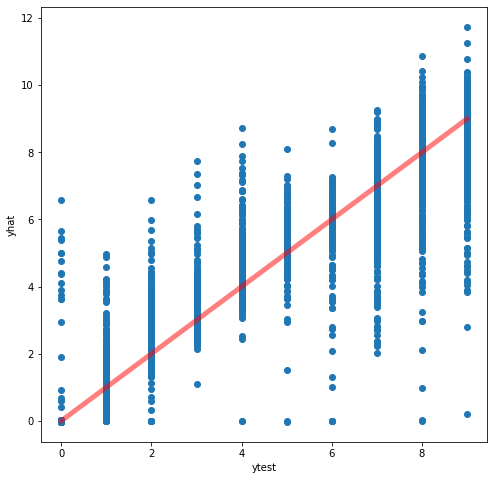

In [169]:
b_yhat = b_cnn.predict(X_test)
f, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(y_test,b_yhat)

ax.plot(np.unique(y_test),np.unique(y_test), linewidth=5, alpha=0.5, color='r')
ax.set_xlabel('ytest')
ax.set_ylabel('yhat') 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

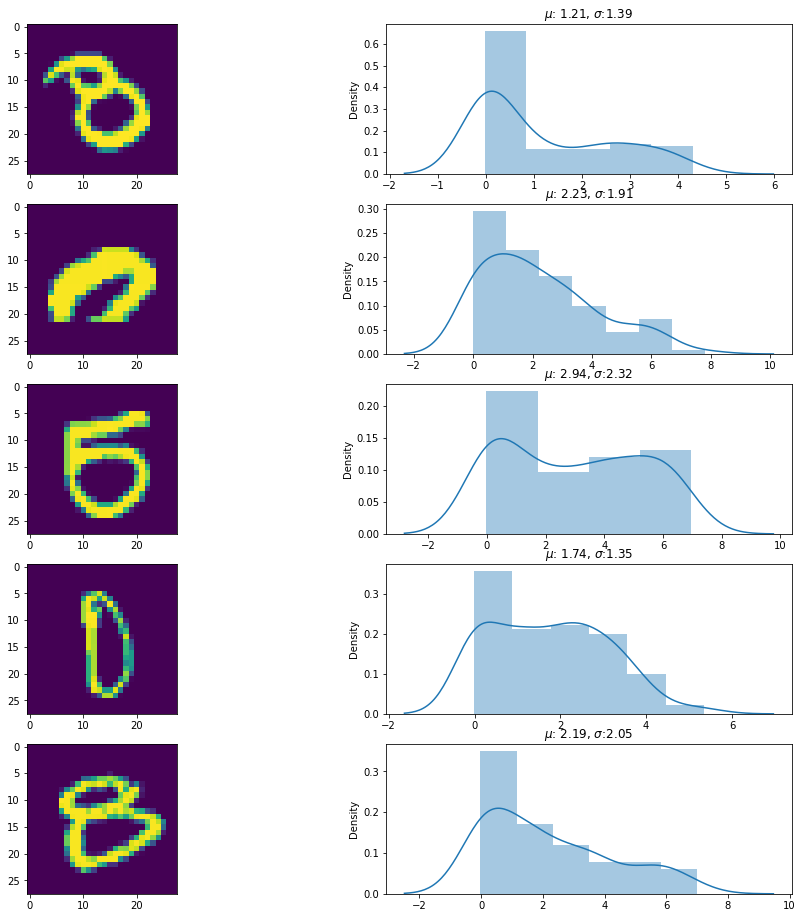

In [135]:
#i = 3030
#i = 4761
thr = 1.2 
uncertain = sorted(np.where(np.std(b_yhat,axis=1)>thr)[0][:5])

f, ax = plt.subplots(len(uncertain),2,figsize=(16,16))
for j, i in enumerate(uncertain):
    ax[j,0].imshow(X_test[i])
    sns.distplot(b_yhat[i], ax=ax[j,1])
    ax[j,1].set_title(fr'$\mu$: {np.mean(b_yhat[i]):0.2f}, $\sigma$:{np.std(b_yhat[i]):0.2f}')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

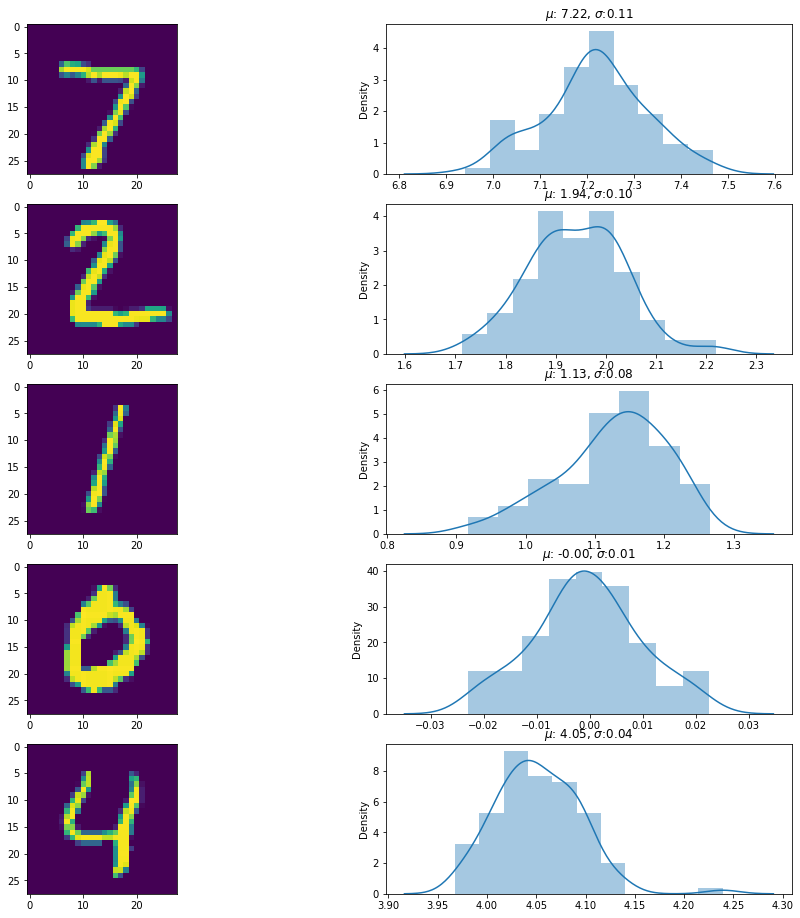

In [136]:
thr = 0.2
uncertain = np.where(np.std(b_yhat,axis=1)<thr)[0][:5]

f, ax = plt.subplots(len(uncertain),2,figsize=(16,16))
for j, i in enumerate(uncertain):
    ax[j,0].imshow(X_test[i])
    sns.distplot(b_yhat[i], ax=ax[j,1])
    ax[j,1].set_title(fr'$\mu$: {np.mean(b_yhat[i]):0.2f}, $\sigma$:{np.std(b_yhat[i]):0.2f}')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'mean=4.03, std=0.34')

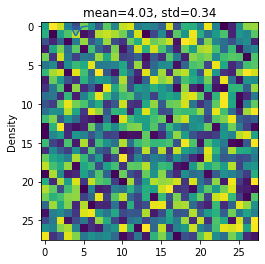

In [168]:
#try trash data
test = np.expand_dims(np.random.random(X_test[0].shape),0)
yout = np.array([b_cnn.predict(test) for i in range(500)])
sns.distplot(yout)
plt.imshow(test[0])
plt.title(f'mean={np.mean(yout):0.2f}, std={np.std(yout):0.2f}')